# Advanced Data Mining

## Models learning

### Classification with Dense Neural Networks

In [1]:


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.__version__

'2.14.0'

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [6]:
!nvidia-smi

Mon Dec 16 17:16:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:21:00.0 Off |                  N/A |
|  0%   53C    P0             105W / 350W |      3MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Data loading

In [3]:
data = pd.read_csv('data/subreddit_body.csv')

In [4]:
df = data[['body', 'subreddit']]

In [5]:
df.head()

,body,subreddit
0,oh morality law work u think exists fed basica...,technology
1,sign contract agree really good deal compare o...,technology
2,logic equivalent people sell gun ammo responsi...,technology
3,sure could go four core like competition seem ...,technology
4,near term hydrogen simply n t compete alternat...,technology


In [6]:
df.subreddit.value_counts()

subreddit
politics       9993
science        9985
programming    9981
technology     9974
gaming         9885
Name: count, dtype: int64

In [7]:
df = pd.concat([df[df['subreddit'] == subreddit].sample(9000, random_state=42)
                for subreddit in df['subreddit'].unique()]).reset_index(drop=True)
df['subreddit'].value_counts()

subreddit
technology     9000
politics       9000
science        9000
gaming         9000
programming    9000
Name: count, dtype: int64

# Word2Vev

In [25]:
import os

os.environ['GENSIM_DATA_DIR'] = '/tf/embedding'

In [8]:
import gensim.downloader as api
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

print("Loading pre-trained Word2Vec model...")
word2vec = api.load("word2vec-google-news-300")

text_data = df['body'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['subreddit'])
labels = y

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text_data)
padded_sequences = pad_sequences(sequences, padding='post')

vocab_size = len(word_index) + 1
embedding_dim = word2vec.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec.key_to_index:
        embedding_matrix[i] = word2vec[word]

Loading pre-trained Word2Vec model...


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Dense Model

In [10]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=padded_sequences.shape[1],
              trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 neurons for 5 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1072, 300)         7788900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

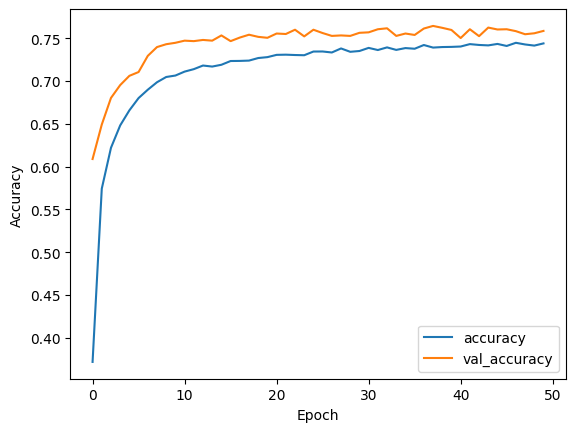

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('report/src/images/dense_accuracy.png')
plt.show()

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.7403, Accuracy: 0.7507


282/282 [==============================] - 0s 1ms/step


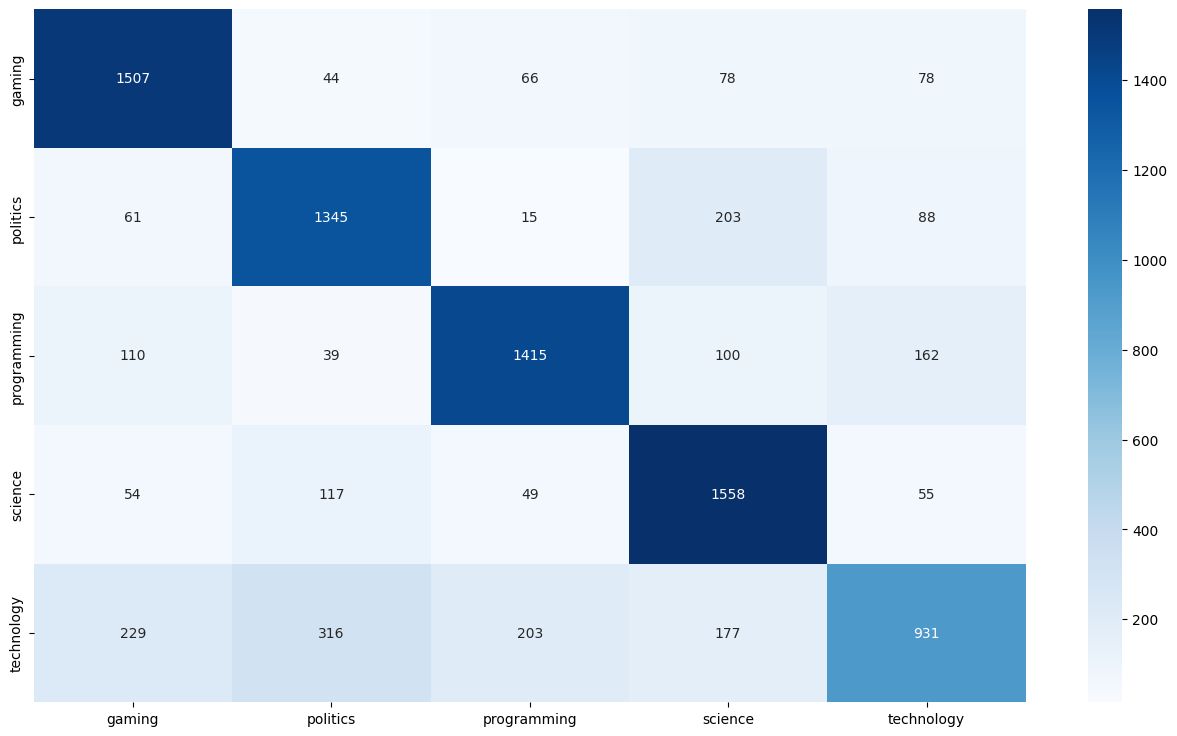

In [13]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/dense_confusion_matrix.png')
plt.show()

282/282 [==============================] - 0s 1ms/step


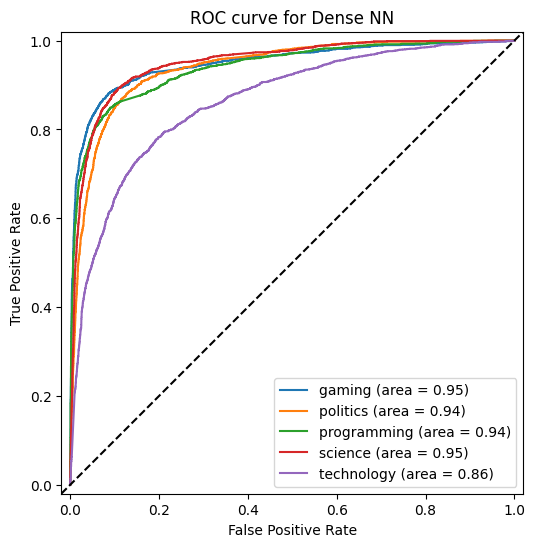

In [14]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

labels = label_encoder.classes_

y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits, 'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for Dense NN')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_dense.png', bbox_inches='tight')
plt.show()

# LSTM Model

In [49]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=padded_sequences.shape[1],
              trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00005), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train,
                    epochs=20, batch_size=128, validation_split=0.1, verbose=1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 1072, 300)         7788900   
                                                                 
 spatial_dropout1d_16 (Spat  (None, 1072, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_42 (Bidirect  (None, 1072, 256)         439296    
 ional)                                                          
                                                                 
 dropout_83 (Dropout)        (None, 1072, 256)         0         
                                                                 
 bidirectional_43 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                     

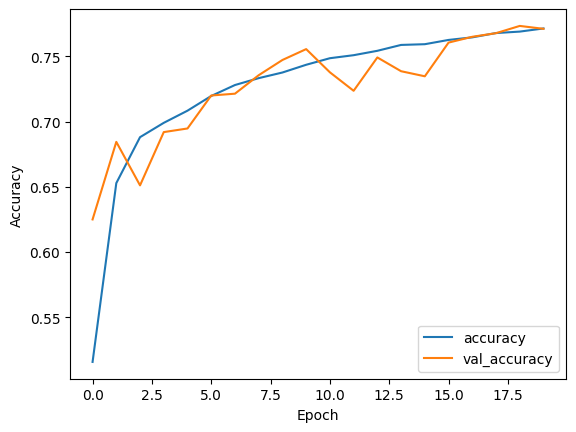

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('lstm_accuracy.png')
plt.show()

In [51]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.6998, Accuracy: 0.7666


282/282 [==============================] - 19s 65ms/step


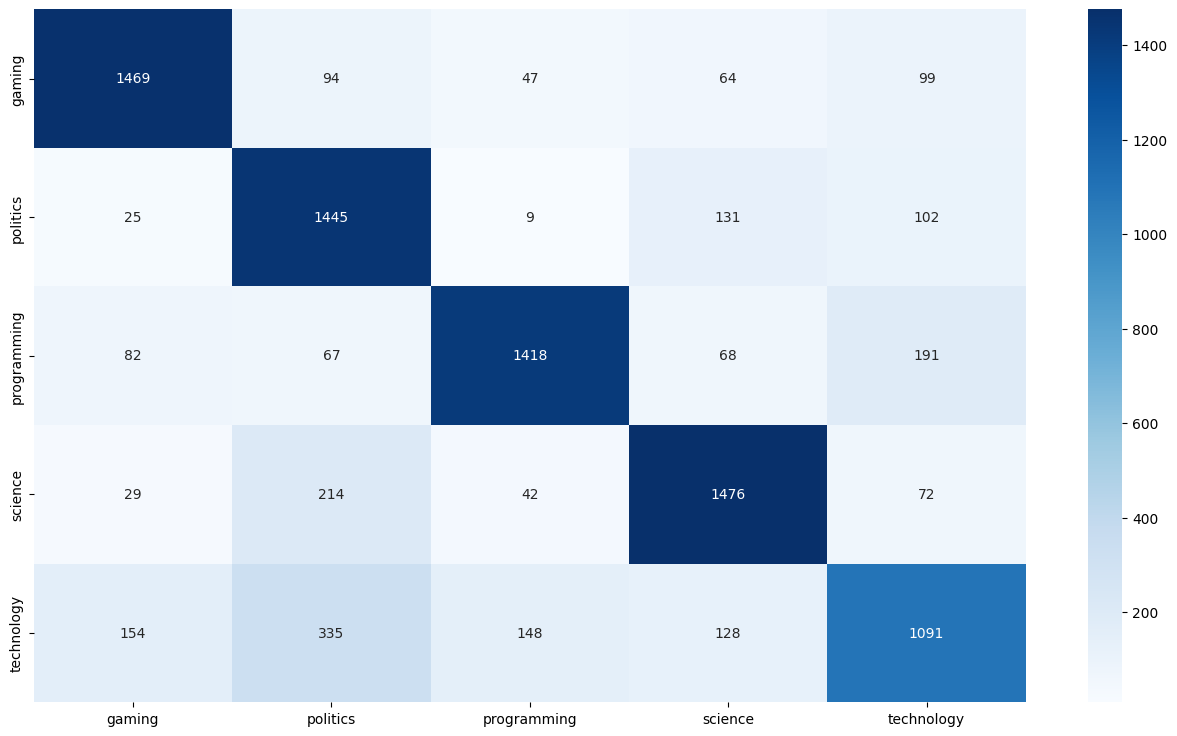

In [52]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.savefig('lstm_confusion_matrix.png')
plt.show()

282/282 [==============================] - 19s 66ms/step


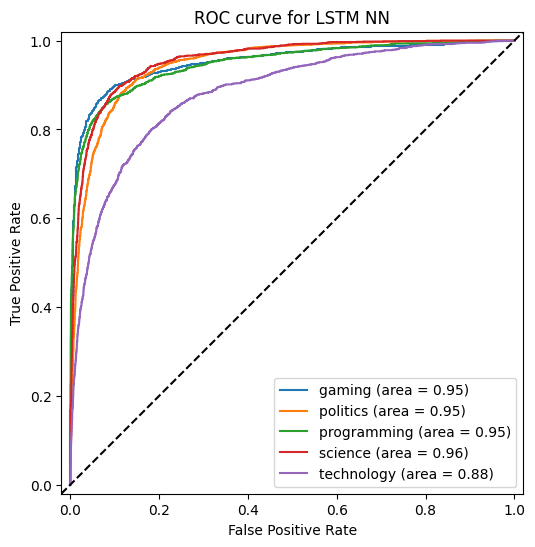

In [53]:
# plot roc curve 

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

labels = label_encoder.classes_

y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits, 'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for LSTM NN')
plt.gca().set_aspect('equal')
plt.savefig(f'roc_lstm.png', bbox_inches='tight')
plt.show()

# LSTM with attention

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Layer


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate attention scores
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Compute context vector as the weighted sum of inputs
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context_vector

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=padded_sequences.shape[1],
                              trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    AttentionLayer(),  # Add the attention layer here
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=32, validation_split=0.1, verbose=1)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 1072, 300)         7788900   
                                                                 
 spatial_dropout1d_17 (Spat  (None, 1072, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_44 (Bidirect  (None, 1072, 256)         439296    
 ional)                                                          
                                                                 
 dropout_88 (Dropout)        (None, 1072, 256)         0         
                                                                 
 bidirectional_45 (Bidirect  (None, 1072, 128)         164352    
 ional)                                                          
                                                     

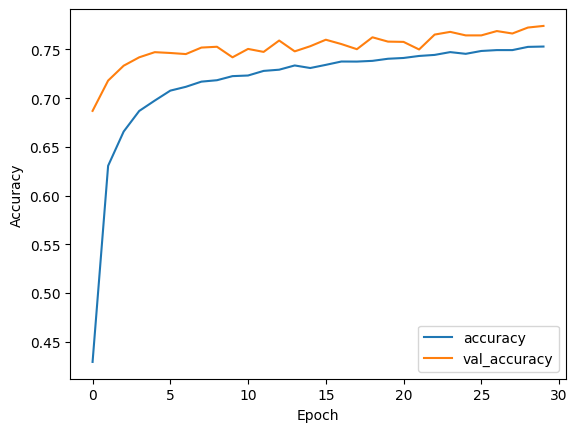

In [56]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('lstm_attention_accuracy.png')
plt.show()

In [57]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.6728, Accuracy: 0.7671


282/282 [==============================] - 20s 69ms/step


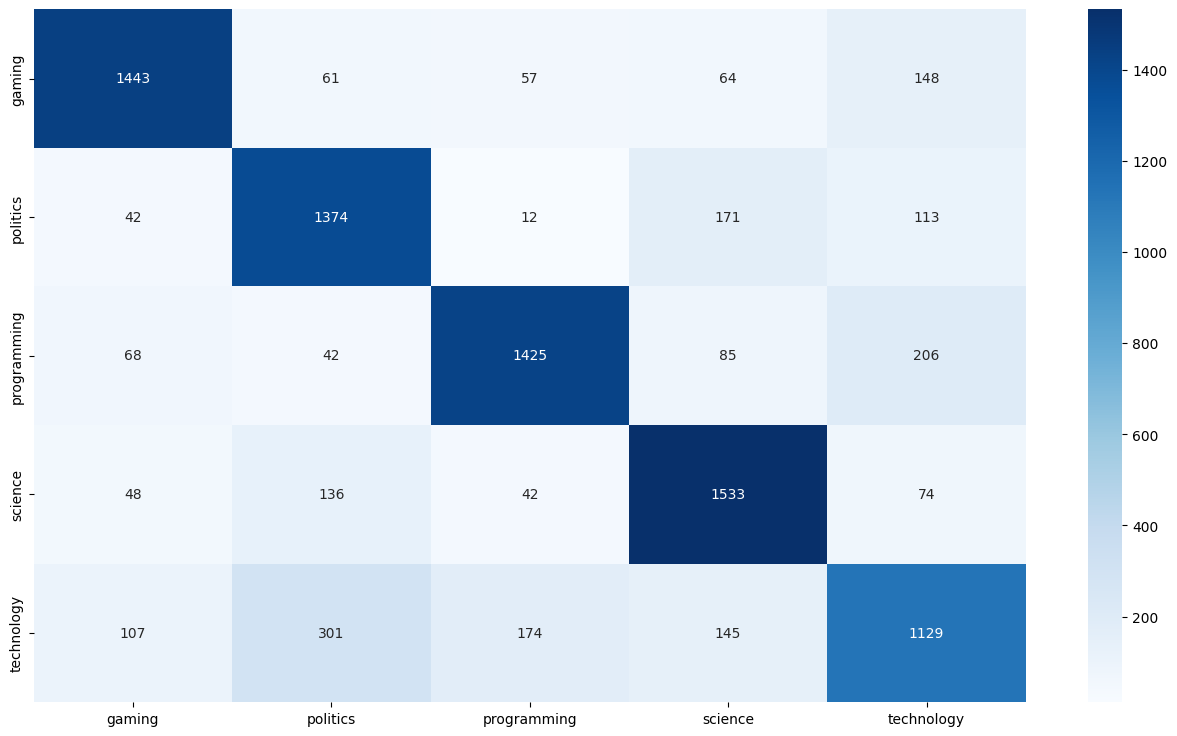

In [58]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.savefig('lstm_attention_confusion_matrix.png')
plt.show()

282/282 [==============================] - 20s 70ms/step


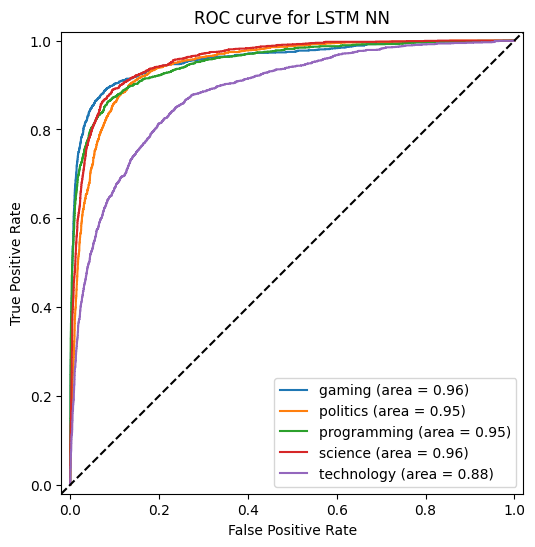

In [59]:
# plot roc curve 

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

labels = label_encoder.classes_

y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits, 'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for LSTM NN')
plt.gca().set_aspect('equal')
plt.savefig(f'roc_lstm_attention.png', bbox_inches='tight')
plt.show()